# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2 - Unsupervised Deep Learning

**General overview**: In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of FashionMNIST. However, you can optionally explore different image collections (e.g., Caltech or Cifar) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the FashionMNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational / adversarial architectures.
Technical notes: The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.


**Final report**: Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.
Grade: The maximum grade for this homework will be 8 points. Points will be assigned based on the correct implementation of the following items:

• 2 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction; explore advanced optimizers and regularization methods

• 1 pt: optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna)

• 1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task, and compare classification accuracy and learning speed with results achieved in Homework 1

• 2 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes

• 2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR


**Deadline**: The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
torch.manual_seed(0)

### Prepare the Dataset
For this part of the homework I will use the Fashion MNIST Dataset

In [ ]:
### Download the dataset and converto to Tensor

data_dir = 'dataset'

train_dataset_MNIST =torchvision.datasets.FashionMNIST(data_dir, train = True, download = True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))
                                            
test_dataset_MNIST =torchvision.datasets.FashionMNIST(data_dir, train = False, download = True,
                                                 transform = transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [ ]:
#Create the validation dataset
from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(train_dataset_MNIST)

Let's define the dataloader

In [ ]:
b_s = 256
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=b_s, shuffle=True)

### Define validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=b_s, shuffle=False)

### Define test dataloader
test_dataloader = DataLoader(test_dataset_MNIST, batch_size=b_s, shuffle=False)

### Define the Autoencoder

In [ ]:
# Firt we define the decoder

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=128, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=128, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, padding=0, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    #Define the array to memorize the error
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #Store the loss
        train_loss = np.append(train_loss, loss.data.cpu())
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def training_validation(optim, loss_fn, train_dataloader, valid_dataloader, encoder, decoder, num_epochs = 20, plot_progress = True, early_stop=0):
        train_loss = []
        train_total_loss = []
        val_total_loss = []
        min_val_loss = 9999
        counter = 0
        early_stop_epoch = 0
        for epoch in range(num_epochs):
            print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training (use the training function)
            train_loss = train_epoch(
                encoder=encoder, 
                decoder=decoder, 
                device=device, 
                dataloader=train_dataloader, 
                loss_fn=loss_fn, 
                optimizer=optim)
            ### Validation  (use the testing function)
            val_loss = test_epoch(
                encoder=encoder, 
                decoder=decoder, 
                device=device, 
                dataloader=valid_dataloader, 
                loss_fn=loss_fn)
            # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, train_loss))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
            #Save the train and validation loss
            train_total_loss = np.append(train_total_loss, train_loss)
            val_total_loss = np.append(val_total_loss, val_loss)
            
            if early_stop != 0:
                if val_loss < min_val_loss:
                    print('\n SAVING NETWORK PARAMETERS....')
                    # Save network parameters
                    torch.save(encoder.state_dict(), 'encoder_params.pth')
                    torch.save(decoder.state_dict(), 'decoder_params.pth')
                    #Update minimum validation and counter
                    min_val_loss = val_loss
                    counter = 0
                    early_stop_epoch = epoch
                else:
                    #Update the counter
                    counter = counter + 1
                    #Check if we have reached the early stop point
                    if counter < early_stop:
                        print(f'Early stop counter: {counter}/{early_stop}')
                    else:
                        print(f'Early stop counter: {counter}/{early_stop}')
                        print('REACHED EARLY STOP POINT')
                        break
            
            if plot_progress:
                if (epoch%2 == 0):
                    ### Plot progress
                    # Get the output of a specific image (the test image at index 0 in this case)
                    img = test_dataset_MNIST[0][0].unsqueeze(0).to(device)
                    encoder.eval()
                    decoder.eval()
                    with torch.no_grad():
                        rec_img  = decoder(encoder(img))
                    # Plot the reconstructed image
                    fig, axs = plt.subplots(1, 2, figsize=(12,6))
                    axs[0].imshow(transforms.ToPILImage()(img.cpu().squeeze()), cmap = 'gist_gray')
                    axs[0].set_title('Original image')
                    axs[1].imshow(transforms.ToPILImage()(rec_img.cpu().squeeze()), cmap = 'gist_gray')
                    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
                    plt.tight_layout()
                    plt.pause(0.1)
                    # Save figures
                    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
                    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
                    plt.show()
                    plt.close()

            # Save network parameters
            torch.save(encoder.state_dict(), 'encoder_params.pth')
            torch.save(decoder.state_dict(), 'decoder_params.pth')


        print(f'\n\n\t AVERAGE TRAINING ERROR: {np.mean(train_total_loss)}')
        print(f'\n\t AVERAGE VALIDATION ERROR: {np.mean(val_total_loss)}')
        print(f'\n\t GENERALIZATION GAP: {abs(np.mean(train_total_loss)-np.mean(val_total_loss))}')
        
        if early_stop != 0:
            return train_total_loss, val_total_loss, early_stop_epoch
        else:
            return train_total_loss, val_total_loss

            # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.143056




	 VALIDATION - EPOCH 1/20 - loss: 0.143220




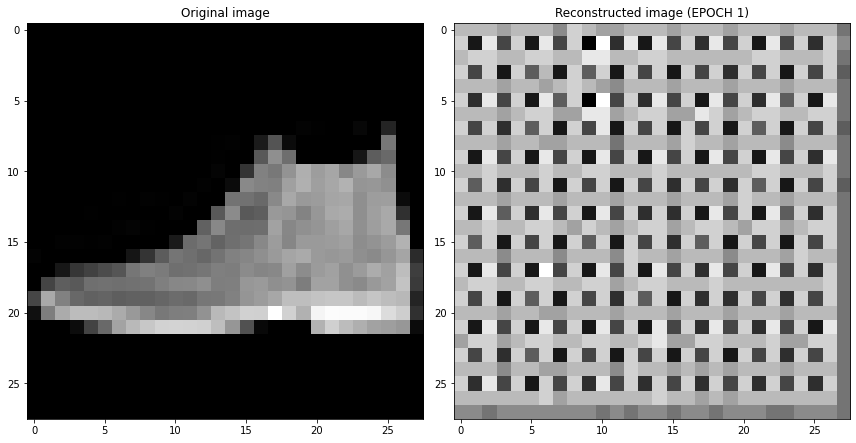

EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.142658




	 VALIDATION - EPOCH 2/20 - loss: 0.142829


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.142285




	 VALIDATION - EPOCH 3/20 - loss: 0.142448




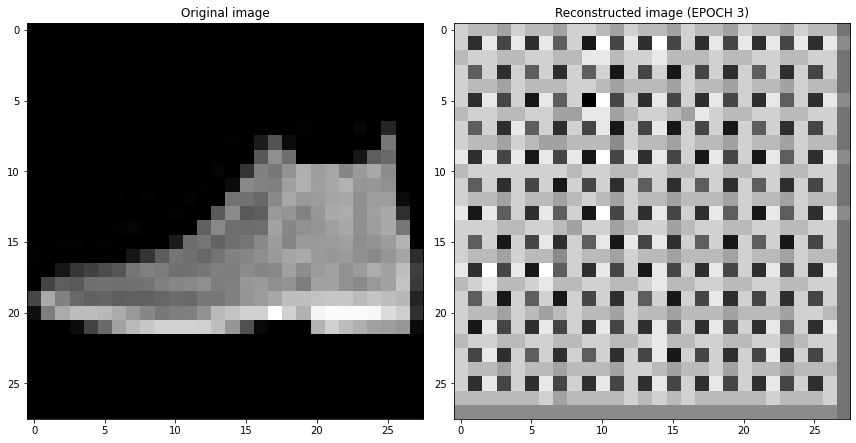

EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.141900




	 VALIDATION - EPOCH 4/20 - loss: 0.142075


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.141533




	 VALIDATION - EPOCH 5/20 - loss: 0.141711




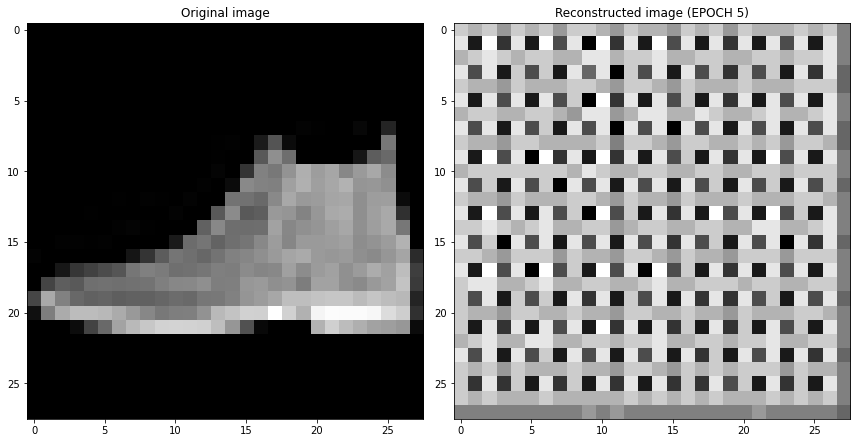

EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.141174




	 VALIDATION - EPOCH 6/20 - loss: 0.141355


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.140820




	 VALIDATION - EPOCH 7/20 - loss: 0.141008




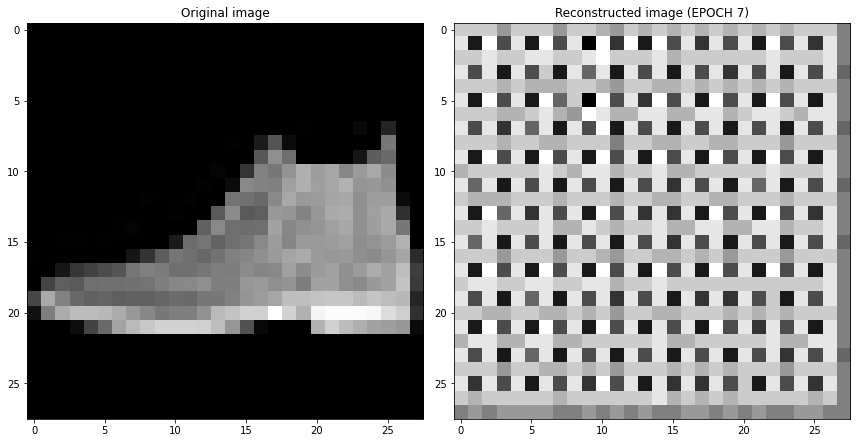

EPOCH 8/20


	 TRAINING - EPOCH 8/20 - loss: 0.140477




	 VALIDATION - EPOCH 8/20 - loss: 0.140669


EPOCH 9/20


	 TRAINING - EPOCH 9/20 - loss: 0.140141




	 VALIDATION - EPOCH 9/20 - loss: 0.140337




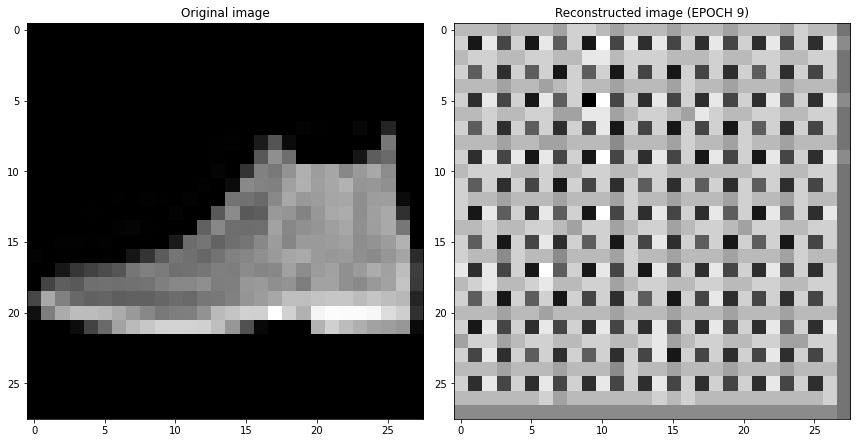

EPOCH 10/20


	 TRAINING - EPOCH 10/20 - loss: 0.139816




	 VALIDATION - EPOCH 10/20 - loss: 0.140014


EPOCH 11/20


	 TRAINING - EPOCH 11/20 - loss: 0.139499




	 VALIDATION - EPOCH 11/20 - loss: 0.139697




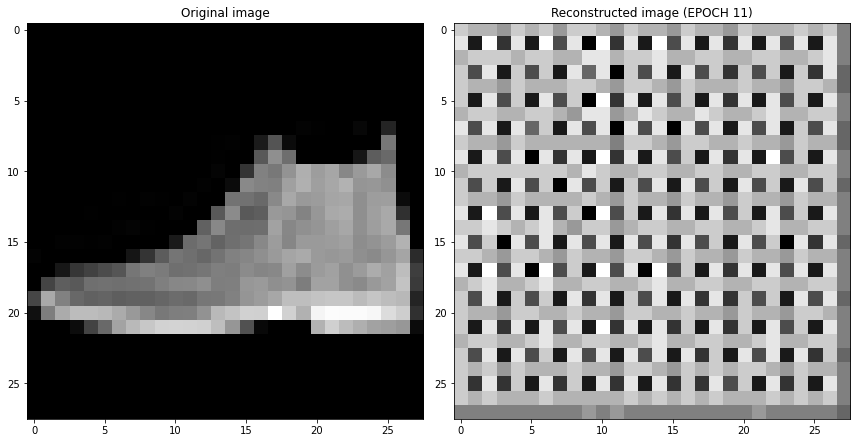

EPOCH 12/20


	 TRAINING - EPOCH 12/20 - loss: 0.139179




	 VALIDATION - EPOCH 12/20 - loss: 0.139388


EPOCH 13/20


	 TRAINING - EPOCH 13/20 - loss: 0.138877




	 VALIDATION - EPOCH 13/20 - loss: 0.139086




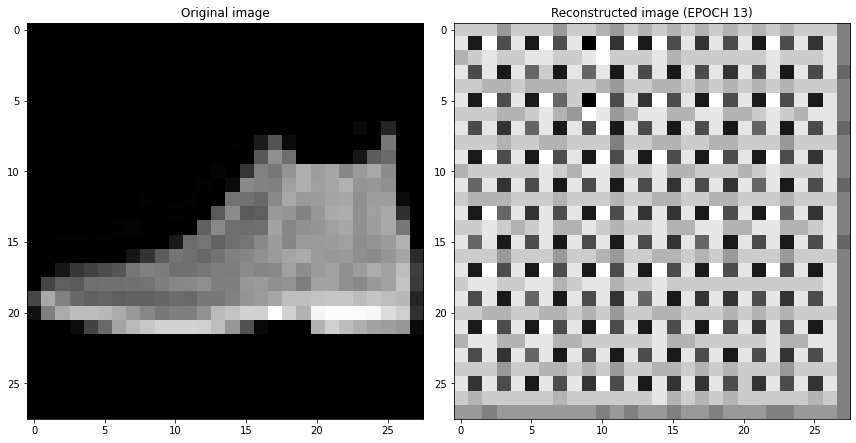

EPOCH 14/20


	 TRAINING - EPOCH 14/20 - loss: 0.138582




	 VALIDATION - EPOCH 14/20 - loss: 0.138791


EPOCH 15/20


	 TRAINING - EPOCH 15/20 - loss: 0.138290




	 VALIDATION - EPOCH 15/20 - loss: 0.138503




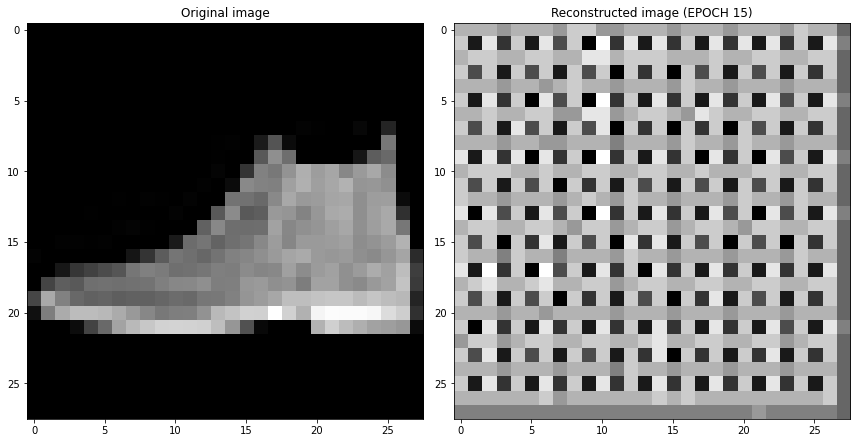

EPOCH 16/20


	 TRAINING - EPOCH 16/20 - loss: 0.138000




	 VALIDATION - EPOCH 16/20 - loss: 0.138221


EPOCH 17/20


	 TRAINING - EPOCH 17/20 - loss: 0.137727




	 VALIDATION - EPOCH 17/20 - loss: 0.137946




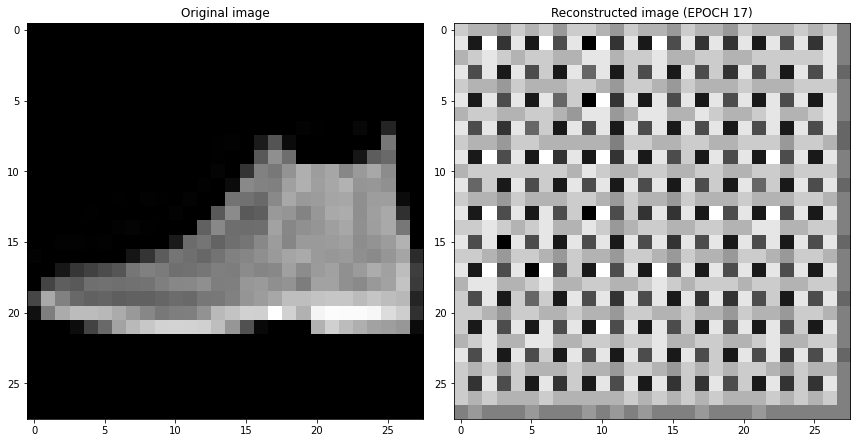

EPOCH 18/20


	 TRAINING - EPOCH 18/20 - loss: 0.137452




	 VALIDATION - EPOCH 18/20 - loss: 0.137677


EPOCH 19/20


	 TRAINING - EPOCH 19/20 - loss: 0.137187




	 VALIDATION - EPOCH 19/20 - loss: 0.137414




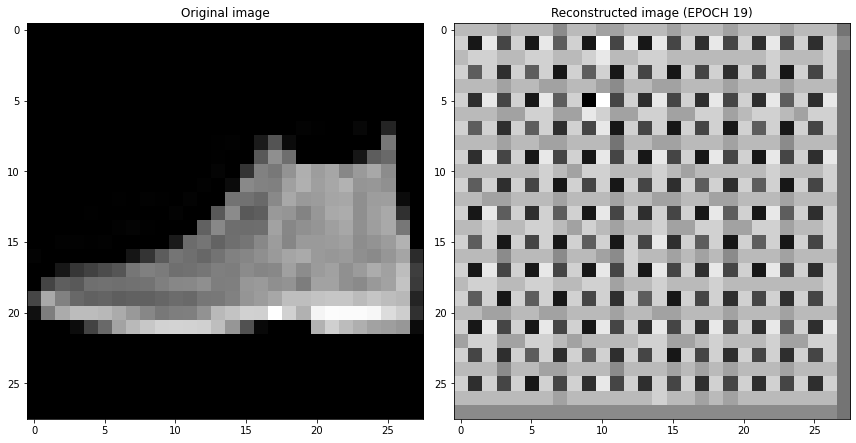

EPOCH 20/20


	 TRAINING - EPOCH 20/20 - loss: 0.136930




	 VALIDATION - EPOCH 20/20 - loss: 0.137157




	 AVERAGE TRAINING ERROR: 0.13977915160781282

	 AVERAGE VALIDATION ERROR: 0.1399772807955742

	 GENERALIZATION GAP: 0.0001981291877613811


In [ ]:
train_total_loss, val_total_loss = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder)

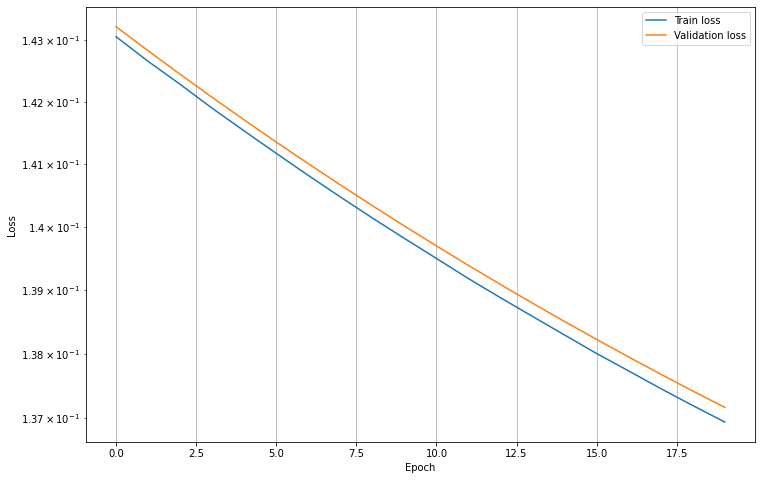

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(train_total_loss, label='Train loss')
plt.semilogy(val_total_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

#### Adamax Optimizer

In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adamax(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.126592




	 VALIDATION - EPOCH 1/20 - loss: 0.096083




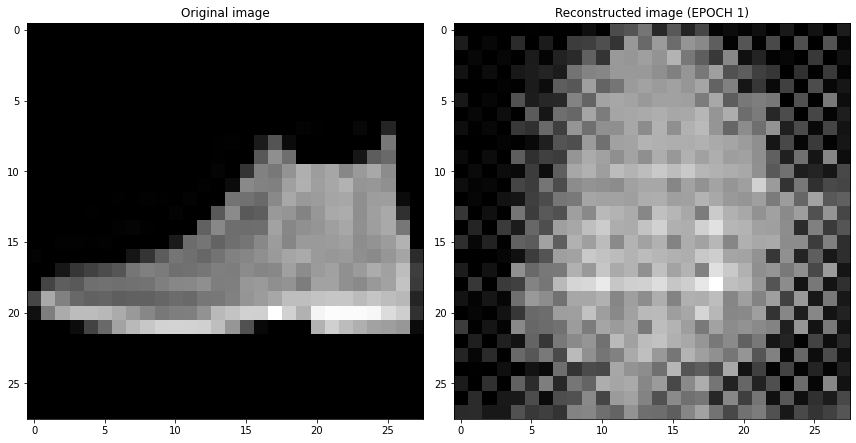

EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.088307




	 VALIDATION - EPOCH 2/20 - loss: 0.085053


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.074443




	 VALIDATION - EPOCH 3/20 - loss: 0.057400




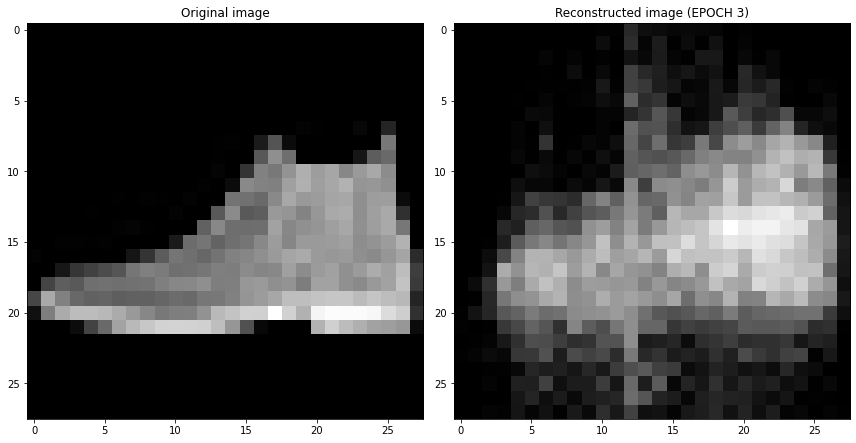

EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.048255




	 VALIDATION - EPOCH 4/20 - loss: 0.044111


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.042751




	 VALIDATION - EPOCH 5/20 - loss: 0.042163




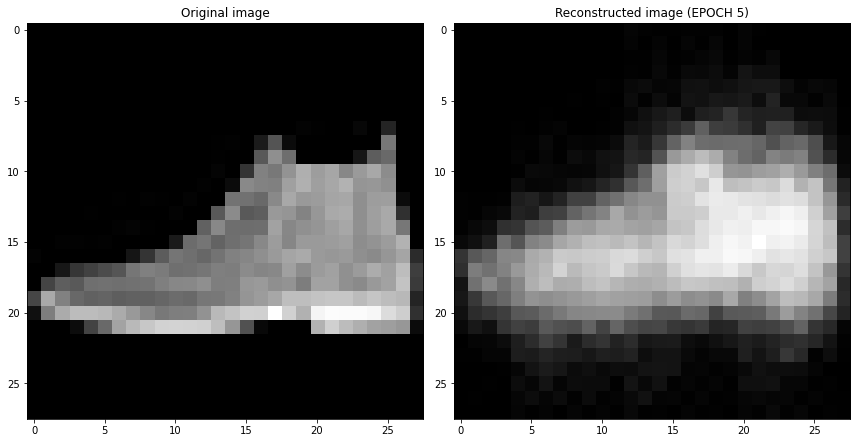

EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.041365




	 VALIDATION - EPOCH 6/20 - loss: 0.041048


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.040455




	 VALIDATION - EPOCH 7/20 - loss: 0.040274




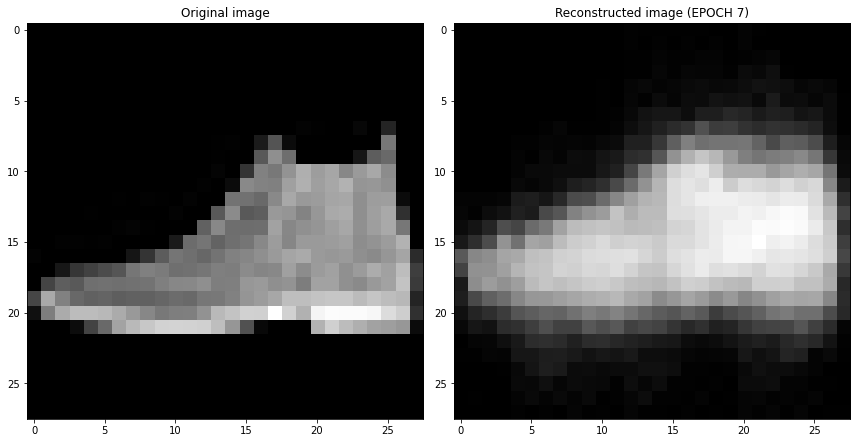

EPOCH 8/20


	 TRAINING - EPOCH 8/20 - loss: 0.039727




	 VALIDATION - EPOCH 8/20 - loss: 0.039589


EPOCH 9/20


	 TRAINING - EPOCH 9/20 - loss: 0.039076




	 VALIDATION - EPOCH 9/20 - loss: 0.038979




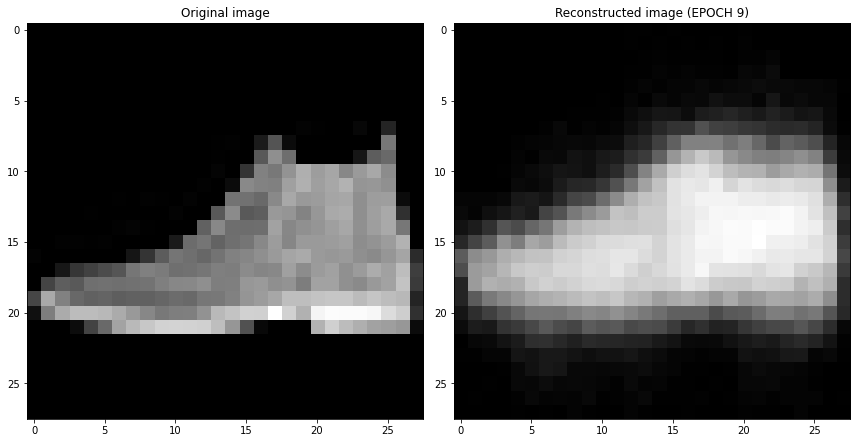

EPOCH 10/20


	 TRAINING - EPOCH 10/20 - loss: 0.038470




	 VALIDATION - EPOCH 10/20 - loss: 0.038349


EPOCH 11/20


	 TRAINING - EPOCH 11/20 - loss: 0.037859




	 VALIDATION - EPOCH 11/20 - loss: 0.037805




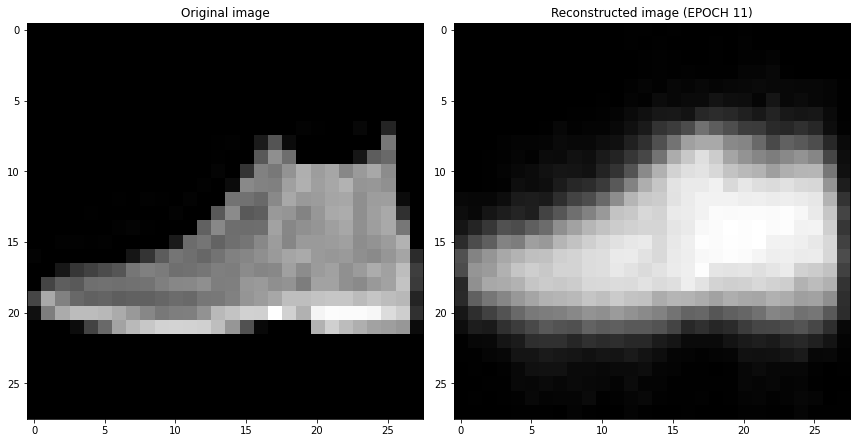

EPOCH 12/20


	 TRAINING - EPOCH 12/20 - loss: 0.037236




	 VALIDATION - EPOCH 12/20 - loss: 0.037158


EPOCH 13/20


	 TRAINING - EPOCH 13/20 - loss: 0.036620




	 VALIDATION - EPOCH 13/20 - loss: 0.036556




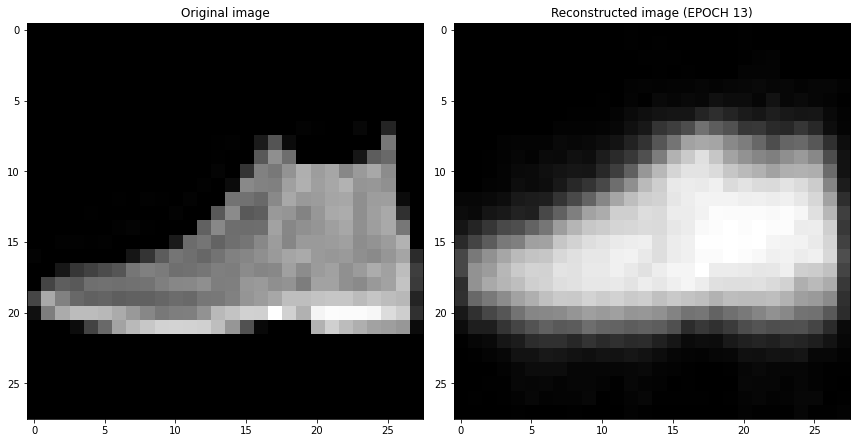

EPOCH 14/20


	 TRAINING - EPOCH 14/20 - loss: 0.036007




	 VALIDATION - EPOCH 14/20 - loss: 0.035951


EPOCH 15/20


	 TRAINING - EPOCH 15/20 - loss: 0.035434




	 VALIDATION - EPOCH 15/20 - loss: 0.035413




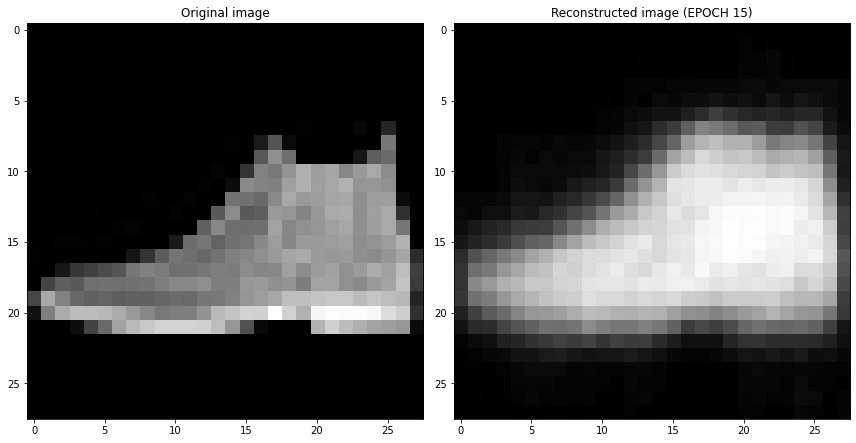

EPOCH 16/20


	 TRAINING - EPOCH 16/20 - loss: 0.034886




	 VALIDATION - EPOCH 16/20 - loss: 0.034860


EPOCH 17/20


	 TRAINING - EPOCH 17/20 - loss: 0.034387




	 VALIDATION - EPOCH 17/20 - loss: 0.034338




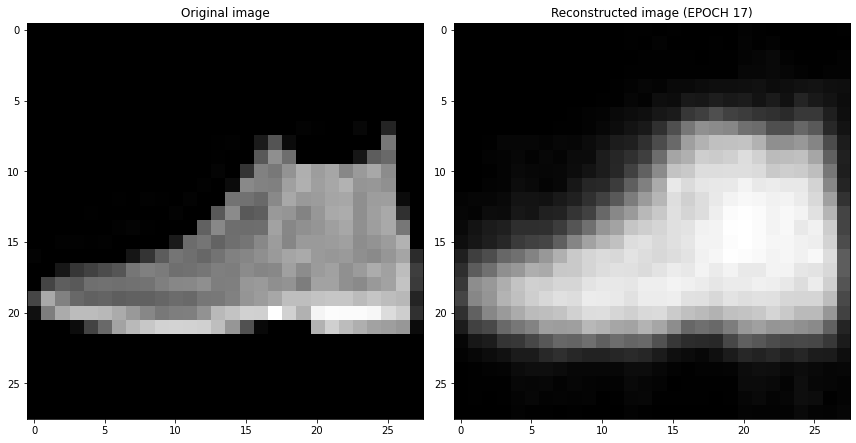

EPOCH 18/20


	 TRAINING - EPOCH 18/20 - loss: 0.033920




	 VALIDATION - EPOCH 18/20 - loss: 0.033892


EPOCH 19/20


	 TRAINING - EPOCH 19/20 - loss: 0.033522




	 VALIDATION - EPOCH 19/20 - loss: 0.033521




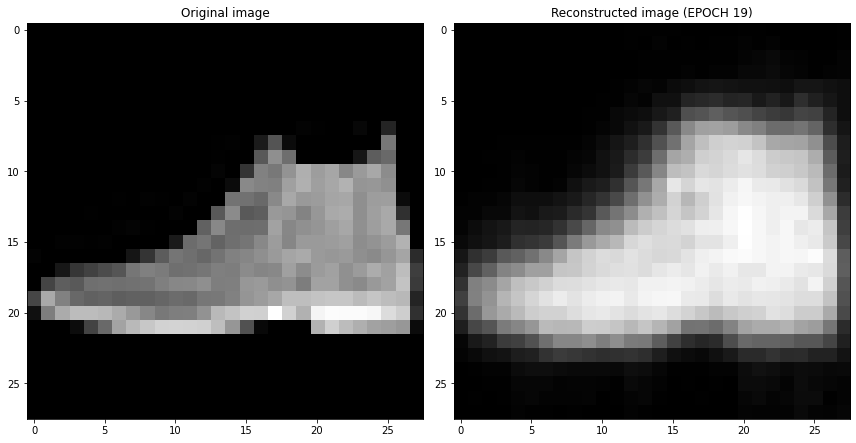

EPOCH 20/20


	 TRAINING - EPOCH 20/20 - loss: 0.033177




	 VALIDATION - EPOCH 20/20 - loss: 0.033195




	 AVERAGE TRAINING ERROR: 0.046624609020496297

	 AVERAGE VALIDATION ERROR: 0.04378684777766466

	 GENERALIZATION GAP: 0.002837761242831638


In [ ]:
train_total_loss, val_total_loss = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder)

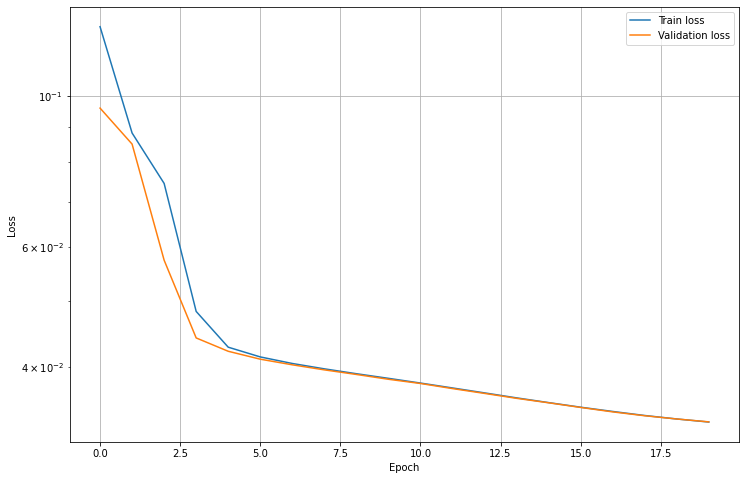

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(train_total_loss, label='Train loss')
plt.semilogy(val_total_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Adam optimizer with l2 regularization

In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.109255




	 VALIDATION - EPOCH 1/20 - loss: 0.073731




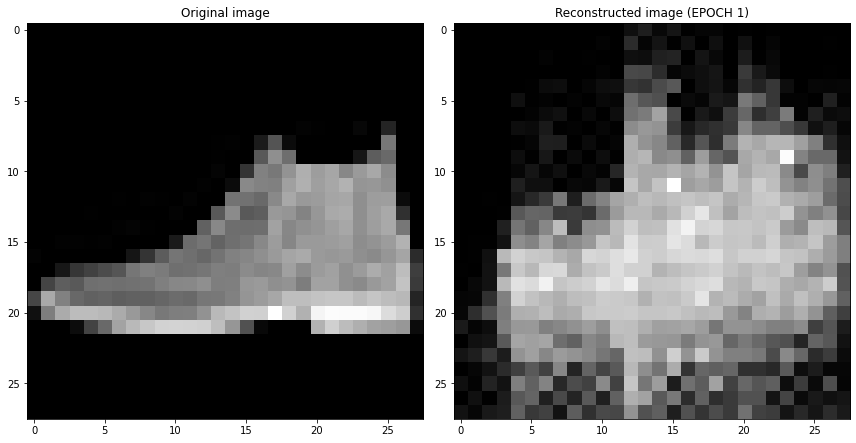

EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.047207




	 VALIDATION - EPOCH 2/20 - loss: 0.041393


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.040180




	 VALIDATION - EPOCH 3/20 - loss: 0.039697




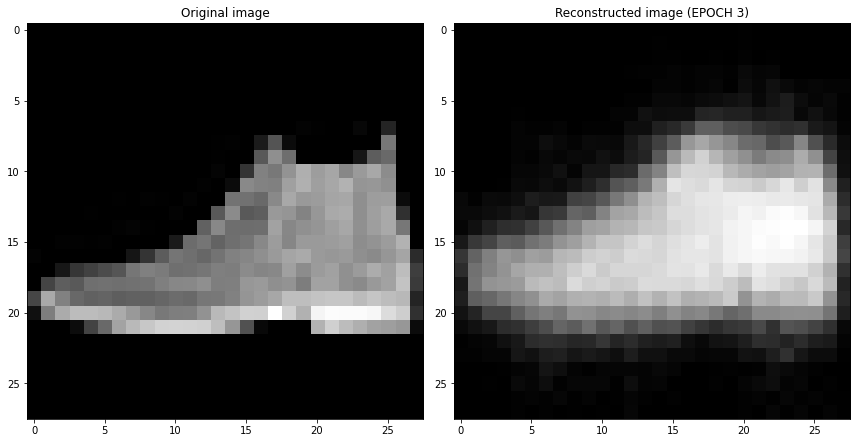

EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.038581




	 VALIDATION - EPOCH 4/20 - loss: 0.038053


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.037186




	 VALIDATION - EPOCH 5/20 - loss: 0.036739




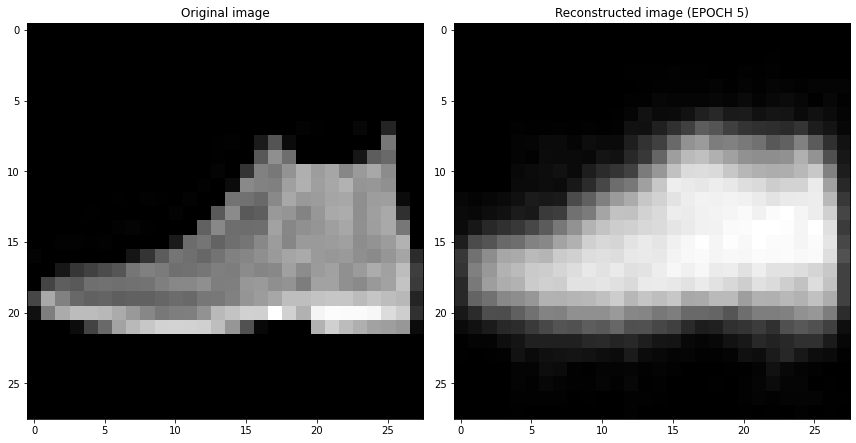

EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.035778




	 VALIDATION - EPOCH 6/20 - loss: 0.035558


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.034600




	 VALIDATION - EPOCH 7/20 - loss: 0.034151




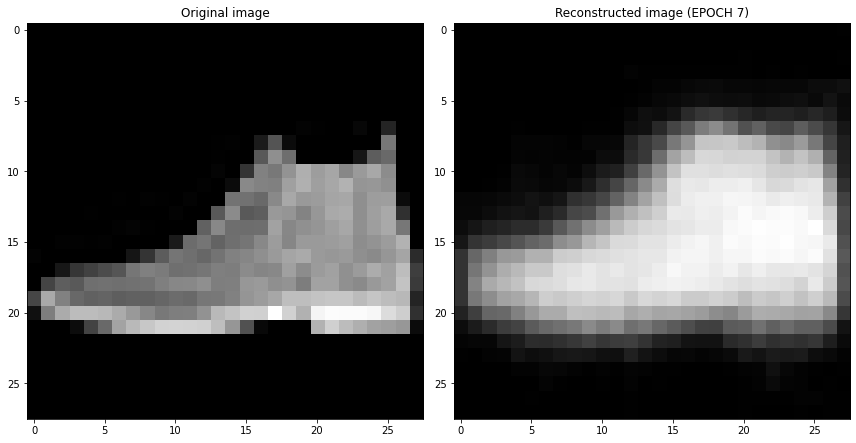

EPOCH 8/20


	 TRAINING - EPOCH 8/20 - loss: 0.033588




	 VALIDATION - EPOCH 8/20 - loss: 0.033294


EPOCH 9/20


	 TRAINING - EPOCH 9/20 - loss: 0.032794




	 VALIDATION - EPOCH 9/20 - loss: 0.032479




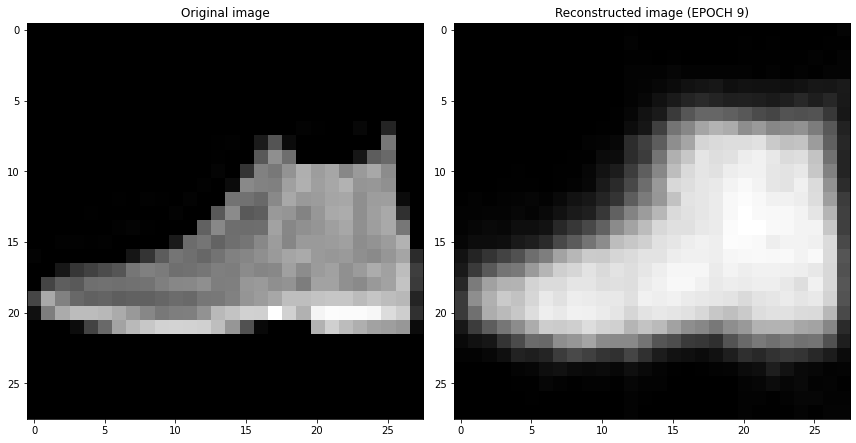

EPOCH 10/20


	 TRAINING - EPOCH 10/20 - loss: 0.032107




	 VALIDATION - EPOCH 10/20 - loss: 0.031938


EPOCH 11/20


	 TRAINING - EPOCH 11/20 - loss: 0.031618




	 VALIDATION - EPOCH 11/20 - loss: 0.031483




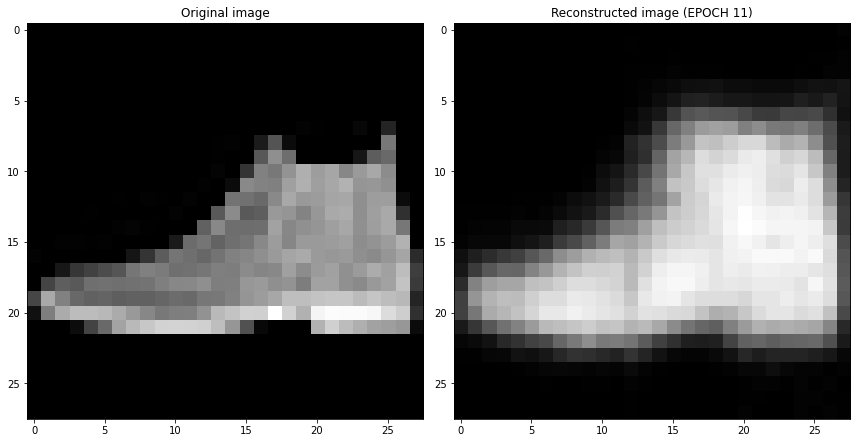

EPOCH 12/20


	 TRAINING - EPOCH 12/20 - loss: 0.031210




	 VALIDATION - EPOCH 12/20 - loss: 0.031255


EPOCH 13/20


	 TRAINING - EPOCH 13/20 - loss: 0.030884




	 VALIDATION - EPOCH 13/20 - loss: 0.030842




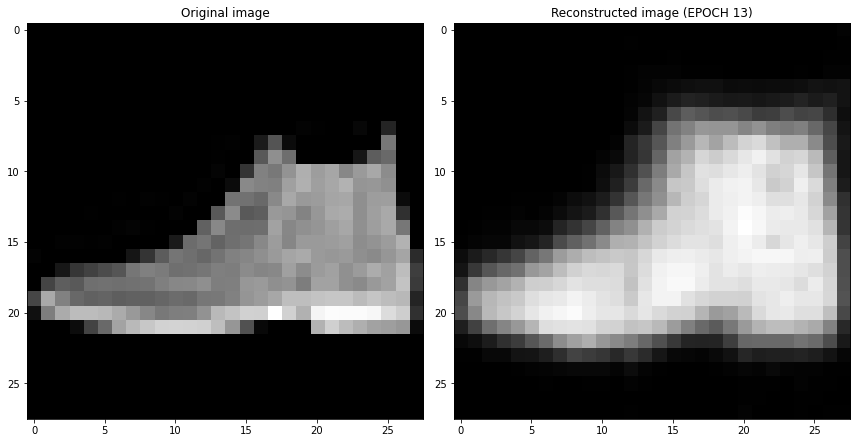

EPOCH 14/20


	 TRAINING - EPOCH 14/20 - loss: 0.030599




	 VALIDATION - EPOCH 14/20 - loss: 0.030600


EPOCH 15/20


	 TRAINING - EPOCH 15/20 - loss: 0.030373




	 VALIDATION - EPOCH 15/20 - loss: 0.030415




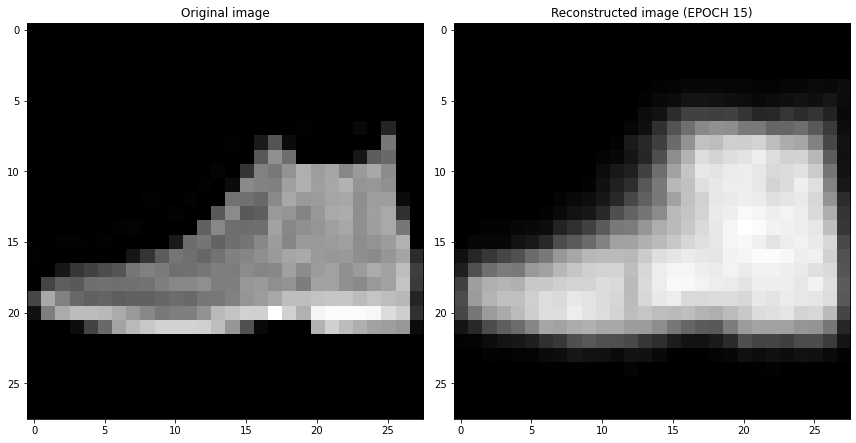

EPOCH 16/20


	 TRAINING - EPOCH 16/20 - loss: 0.030184




	 VALIDATION - EPOCH 16/20 - loss: 0.030264


EPOCH 17/20


	 TRAINING - EPOCH 17/20 - loss: 0.029991




	 VALIDATION - EPOCH 17/20 - loss: 0.030020




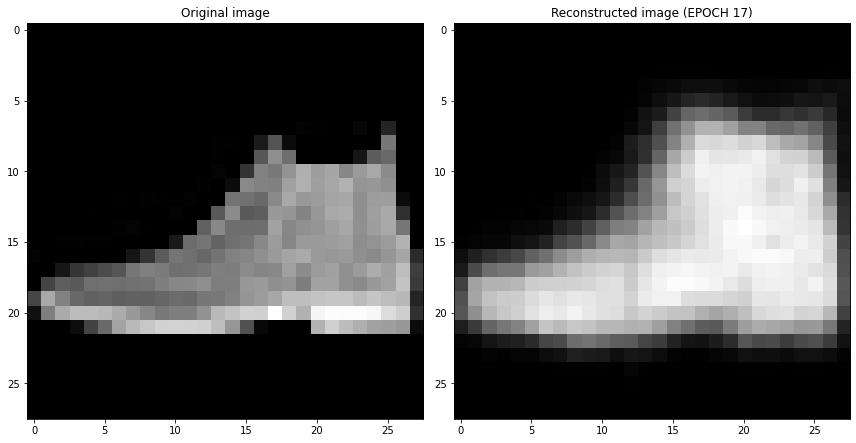

EPOCH 18/20


	 TRAINING - EPOCH 18/20 - loss: 0.029821




	 VALIDATION - EPOCH 18/20 - loss: 0.029958


EPOCH 19/20


	 TRAINING - EPOCH 19/20 - loss: 0.029729




	 VALIDATION - EPOCH 19/20 - loss: 0.029706




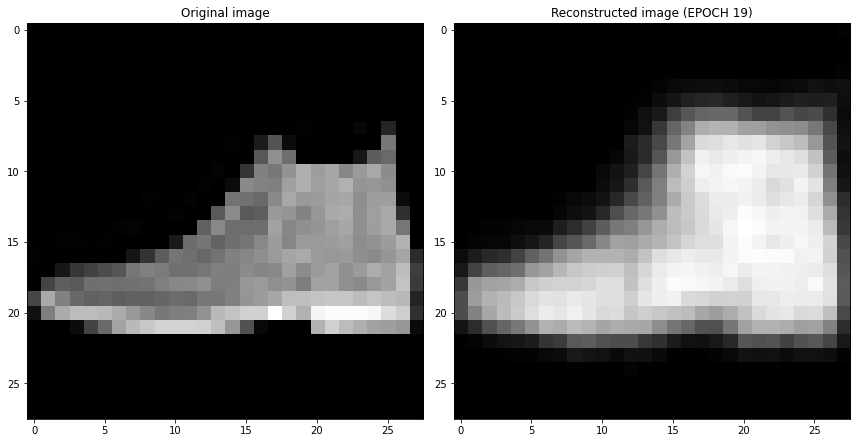

EPOCH 20/20


	 TRAINING - EPOCH 20/20 - loss: 0.029560




	 VALIDATION - EPOCH 20/20 - loss: 0.029631




	 AVERAGE TRAINING ERROR: 0.037262275800722736

	 AVERAGE VALIDATION ERROR: 0.03506034854799509

	 GENERALIZATION GAP: 0.0022019272527276437


In [ ]:
train_total_loss, val_total_loss = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder)

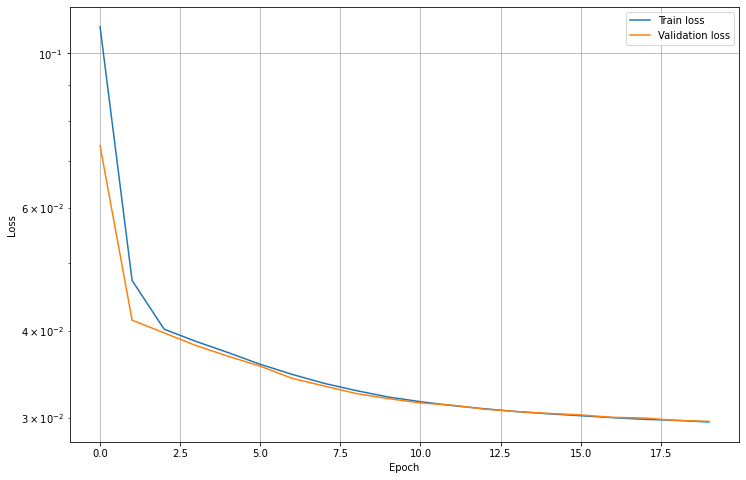

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(train_total_loss, label='Train loss')
plt.semilogy(val_total_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Regularization: Batch Normalization
In this part of the homework we will try to improve the basic CNN autoencoder by adding a batch normalization layer that will help our network to reduce the generalizzation gap.

In [ ]:
# Firt we define the decoder

class Batch_Norm_Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
         ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*32, out_features=128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=128, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:

class Batch_Norm_Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=128, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))

        ### Convolutional section
        self.decoder_cnn = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )

        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_cnn(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Batch_Norm_Encoder(encoded_space_dim=encoded_space_dim)
decoder = Batch_Norm_Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Batch_Norm_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.096597




	 VALIDATION - EPOCH 1/20 - loss: 0.056201




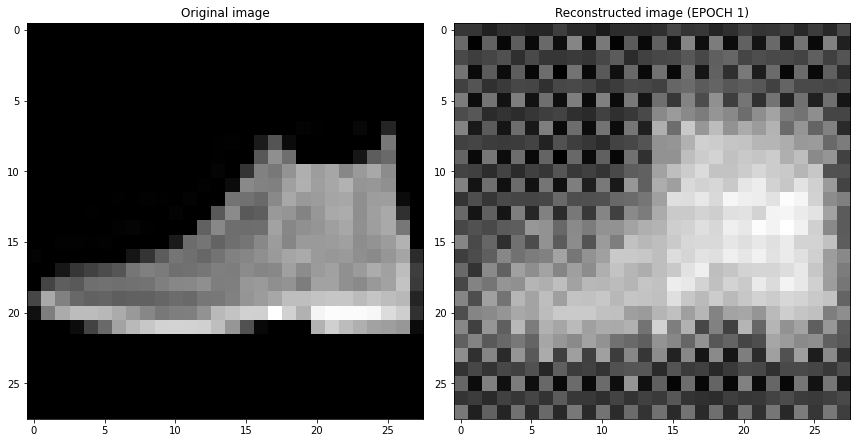

EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.045217




	 VALIDATION - EPOCH 2/20 - loss: 0.038695


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.035749




	 VALIDATION - EPOCH 3/20 - loss: 0.033908




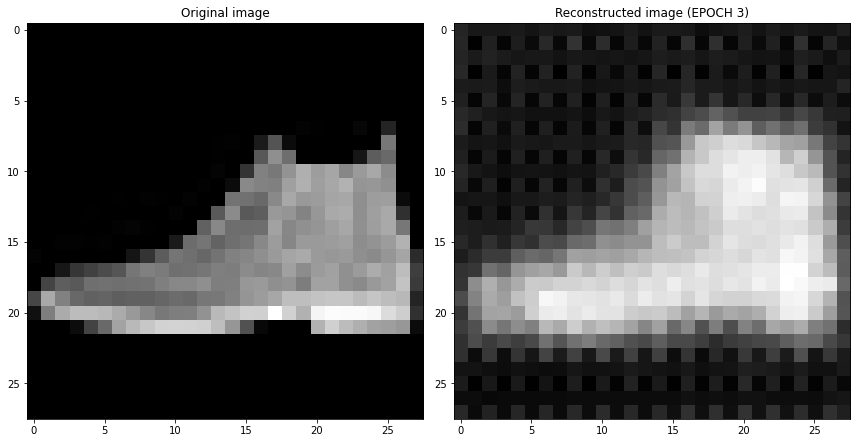

EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.032726




	 VALIDATION - EPOCH 4/20 - loss: 0.031831


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.031256




	 VALIDATION - EPOCH 5/20 - loss: 0.030717




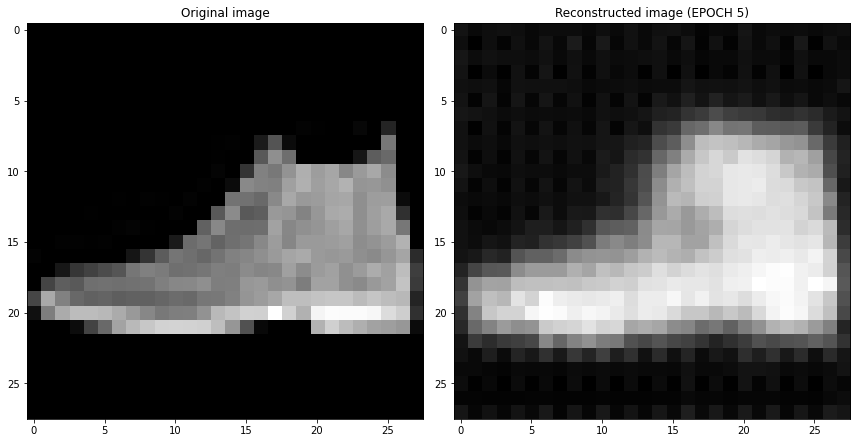

EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.030343




	 VALIDATION - EPOCH 6/20 - loss: 0.030114


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.029747




	 VALIDATION - EPOCH 7/20 - loss: 0.029577




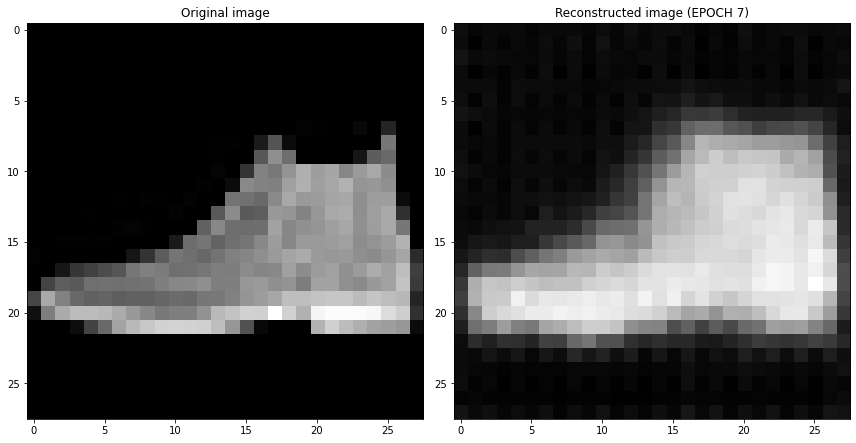

EPOCH 8/20


	 TRAINING - EPOCH 8/20 - loss: 0.029325




	 VALIDATION - EPOCH 8/20 - loss: 0.029039


EPOCH 9/20


	 TRAINING - EPOCH 9/20 - loss: 0.028956




	 VALIDATION - EPOCH 9/20 - loss: 0.028918




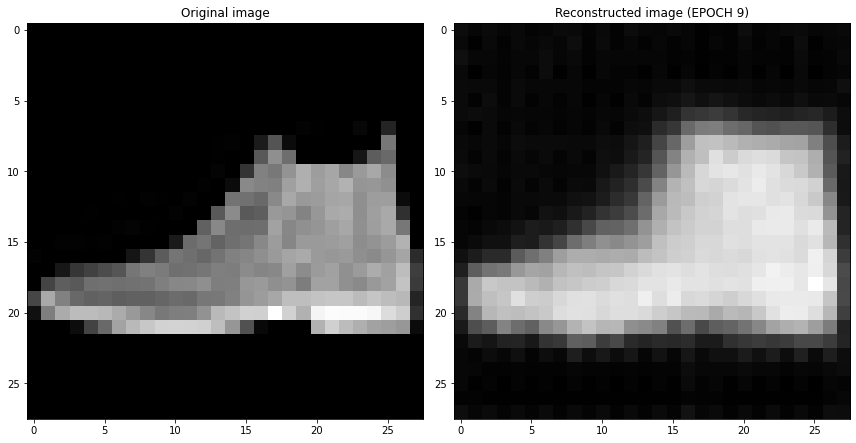

EPOCH 10/20


	 TRAINING - EPOCH 10/20 - loss: 0.028664




	 VALIDATION - EPOCH 10/20 - loss: 0.028703


EPOCH 11/20


	 TRAINING - EPOCH 11/20 - loss: 0.028403




	 VALIDATION - EPOCH 11/20 - loss: 0.028488




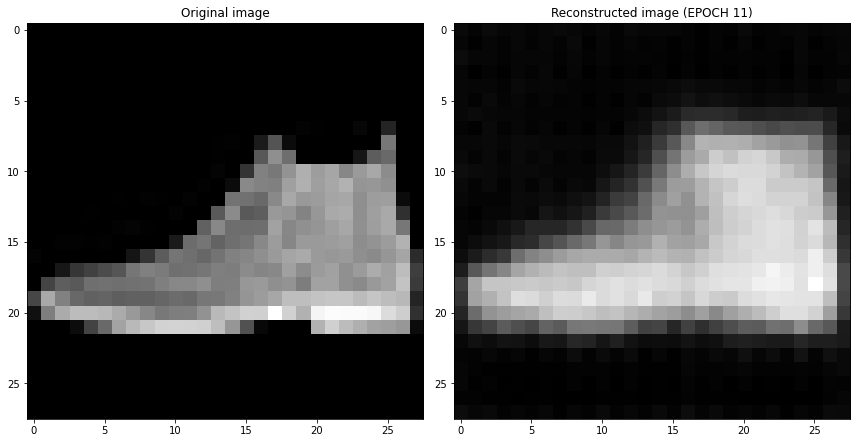

EPOCH 12/20


	 TRAINING - EPOCH 12/20 - loss: 0.028220




	 VALIDATION - EPOCH 12/20 - loss: 0.028331


EPOCH 13/20


	 TRAINING - EPOCH 13/20 - loss: 0.027963




	 VALIDATION - EPOCH 13/20 - loss: 0.028010




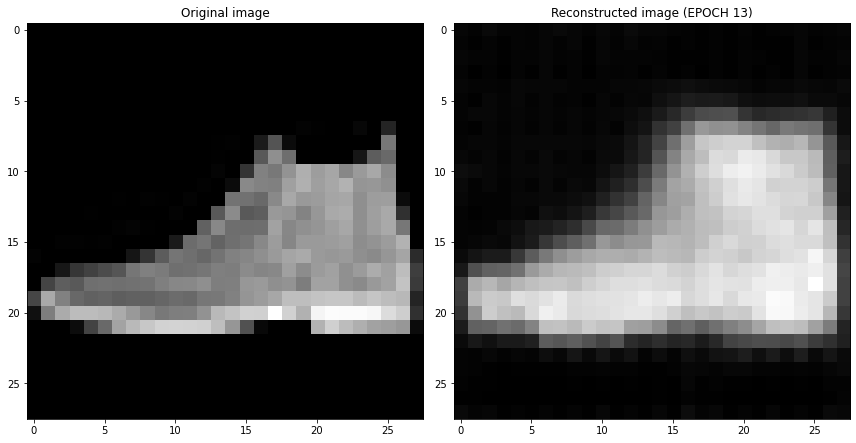

EPOCH 14/20


	 TRAINING - EPOCH 14/20 - loss: 0.027864




	 VALIDATION - EPOCH 14/20 - loss: 0.027846


EPOCH 15/20


	 TRAINING - EPOCH 15/20 - loss: 0.027721




	 VALIDATION - EPOCH 15/20 - loss: 0.027794




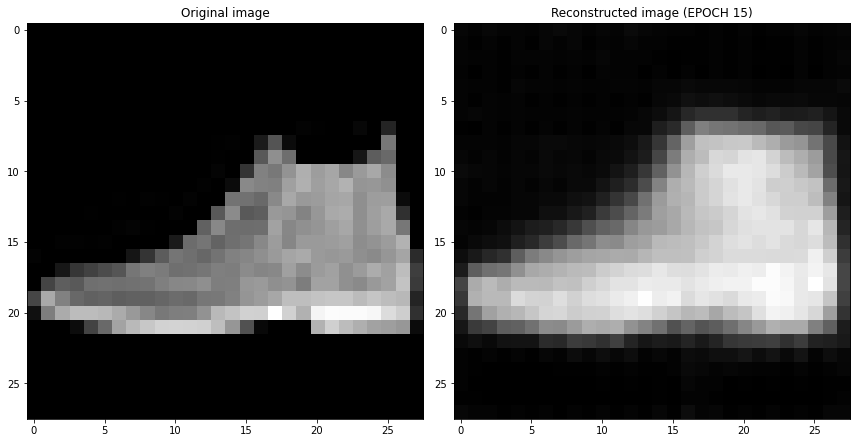

EPOCH 16/20


	 TRAINING - EPOCH 16/20 - loss: 0.027563




	 VALIDATION - EPOCH 16/20 - loss: 0.027695


EPOCH 17/20


	 TRAINING - EPOCH 17/20 - loss: 0.027474




	 VALIDATION - EPOCH 17/20 - loss: 0.027831




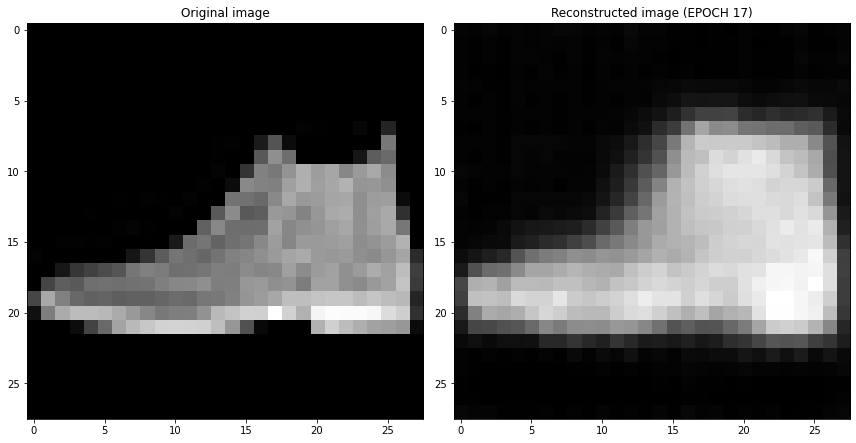

EPOCH 18/20


	 TRAINING - EPOCH 18/20 - loss: 0.027357




	 VALIDATION - EPOCH 18/20 - loss: 0.027509


EPOCH 19/20


	 TRAINING - EPOCH 19/20 - loss: 0.027217




	 VALIDATION - EPOCH 19/20 - loss: 0.027460




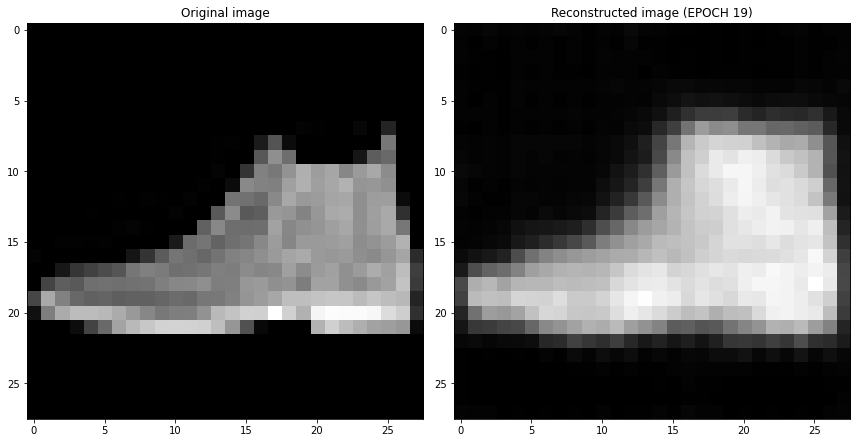

EPOCH 20/20


	 TRAINING - EPOCH 20/20 - loss: 0.027138




	 VALIDATION - EPOCH 20/20 - loss: 0.027233




	 AVERAGE TRAINING ERROR: 0.03327489586769265

	 AVERAGE VALIDATION ERROR: 0.030794996581971646

	 GENERALIZATION GAP: 0.0024798992857210066


In [ ]:
train_total_loss, val_total_loss = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder)

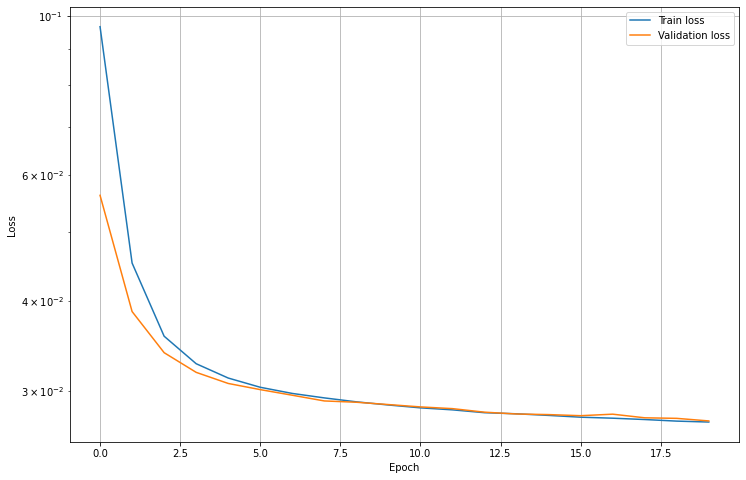

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(train_total_loss, label='Train loss')
plt.semilogy(val_total_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

### Optimizing latent space with Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna.integration import PyTorchIgnitePruningHandler

def objective(trial):

    # We optimize the number of neurons in the latent space.
    dim_latent_space = trial.suggest_int("dim_latent_space", 2, 128, log=True)

    encoder = Batch_Norm_Encoder(dim_latent_space)
    decoder = Batch_Norm_Decoder(dim_latent_space)
    
    lr = trial.suggest_uniform("lr", 5e-4, 5e-2) # Learning rate
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

    # Check if the GPU is available
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    print(f'Selected device: {device}') 
    
    encoder.to(device)
    decoder.to(device)

    _ , val_total_loss = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder, plot_progress = False)
    
    val_loss = np.mean(val_total_loss)

    return val_loss

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

study = optuna.create_study(study_name="optimize_neurons_latent_space_and_learning_rate", direction="minimize", pruner = pruner)
study.optimize(objective, n_trials=5, timeout=300)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-02-04 00:05:01,131] A new study created in memory with name: optimize_neurons_latent_space_and_learning_rate


Selected device: cuda
EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.045407




	 VALIDATION - EPOCH 1/20 - loss: 0.043707


EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.026737




	 VALIDATION - EPOCH 2/20 - loss: 0.025963


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.023723




	 VALIDATION - EPOCH 3/20 - loss: 0.023113


EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.022612




	 VALIDATION - EPOCH 4/20 - loss: 0.021627


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.021376




	 VALIDATION - EPOCH 5/20 - loss: 0.020941


EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.020510




	 VALIDATION - EPOCH 6/20 - loss: 0.020307


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.019881




	 VALIDATION - EPOCH 7/20 - loss: 0.020152


EPOCH 8/20


	 TRAINING - EPOCH 8/20 - loss: 0.019449




	 VALIDATION - EPOCH 8/20 - loss: 0.019347


EPOCH 9/20


	 TRAINING - EPOCH 9/20 - loss: 0.019410




	 VALIDATION - EPOCH 9/20 - loss: 0.018621


EPOCH 10/20


	 TRAINING - EPOCH 10/20 - loss: 0.01

[I 2022-02-04 00:05:29,735] Trial 0 finished with value: 0.02214319258928299 and parameters: {'dim_latent_space': 9, 'lr': 0.045296178421477956}. Best is trial 0 with value: 0.02214319258928299.




	 TRAINING - EPOCH 20/20 - loss: 0.017885




	 VALIDATION - EPOCH 20/20 - loss: 0.018227




	 AVERAGE TRAINING ERROR: 0.02110228319070302

	 AVERAGE VALIDATION ERROR: 0.02214319258928299

	 GENERALIZATION GAP: 0.0010409093985799707
Selected device: cuda
EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.055760




	 VALIDATION - EPOCH 1/20 - loss: 0.033217


EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.027796




	 VALIDATION - EPOCH 2/20 - loss: 0.025037


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.023059




	 VALIDATION - EPOCH 3/20 - loss: 0.022312


EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.021365




	 VALIDATION - EPOCH 4/20 - loss: 0.020627


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.020050




	 VALIDATION - EPOCH 5/20 - loss: 0.018784


EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.018637




	 VALIDATION - EPOCH 6/20 - loss: 0.018417


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.017752




	 VALIDATION - EPOCH 7/20 - loss: 0.017236


EPOCH 8/20


	 TRAINI

[I 2022-02-04 00:05:58,190] Trial 1 finished with value: 0.01748463804833591 and parameters: {'dim_latent_space': 126, 'lr': 0.011237560231408716}. Best is trial 1 with value: 0.01748463804833591.




	 TRAINING - EPOCH 20/20 - loss: 0.013565




	 VALIDATION - EPOCH 20/20 - loss: 0.013360




	 AVERAGE TRAINING ERROR: 0.018865796556664545

	 AVERAGE VALIDATION ERROR: 0.01748463804833591

	 GENERALIZATION GAP: 0.0013811585083286365
Selected device: cuda
EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.055207




	 VALIDATION - EPOCH 1/20 - loss: 0.049430


EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.030394




	 VALIDATION - EPOCH 2/20 - loss: 0.027308


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.024440




	 VALIDATION - EPOCH 3/20 - loss: 0.032153


EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.022040




	 VALIDATION - EPOCH 4/20 - loss: 0.021032


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.021137




	 VALIDATION - EPOCH 5/20 - loss: 0.020953


EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.020238




	 VALIDATION - EPOCH 6/20 - loss: 0.021322


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.019688




	 VALIDATION - EPOCH 7/20 - loss: 0.019586


EPOCH 8/20


	 TRAIN

[I 2022-02-04 00:06:26,422] Trial 2 finished with value: 0.021546449419111012 and parameters: {'dim_latent_space': 58, 'lr': 0.04175599631885489}. Best is trial 1 with value: 0.01748463804833591.




	 TRAINING - EPOCH 20/20 - loss: 0.017850




	 VALIDATION - EPOCH 20/20 - loss: 0.017665




	 AVERAGE TRAINING ERROR: 0.021091227905443787

	 AVERAGE VALIDATION ERROR: 0.021546449419111012

	 GENERALIZATION GAP: 0.0004552215136672255
Selected device: cuda
EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.052216




	 VALIDATION - EPOCH 1/20 - loss: 0.040760


EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.027334




	 VALIDATION - EPOCH 2/20 - loss: 0.026956


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.024105




	 VALIDATION - EPOCH 3/20 - loss: 0.023650


EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.022874




	 VALIDATION - EPOCH 4/20 - loss: 0.022756


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.021778




	 VALIDATION - EPOCH 5/20 - loss: 0.020898


EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.020901




	 VALIDATION - EPOCH 6/20 - loss: 0.020824


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.020047




	 VALIDATION - EPOCH 7/20 - loss: 0.019802


EPOCH 8/20


	 TRAI

[I 2022-02-04 00:06:54,707] Trial 3 finished with value: 0.021130939200520515 and parameters: {'dim_latent_space': 14, 'lr': 0.043922580343266654}. Best is trial 1 with value: 0.01748463804833591.




	 TRAINING - EPOCH 20/20 - loss: 0.016727




	 VALIDATION - EPOCH 20/20 - loss: 0.016634




	 AVERAGE TRAINING ERROR: 0.021119605788738807

	 AVERAGE VALIDATION ERROR: 0.021130939200520515

	 GENERALIZATION GAP: 1.1333411781708214e-05
Selected device: cuda
EPOCH 1/20


	 TRAINING - EPOCH 1/20 - loss: 0.046972




	 VALIDATION - EPOCH 1/20 - loss: 0.036441


EPOCH 2/20


	 TRAINING - EPOCH 2/20 - loss: 0.027906




	 VALIDATION - EPOCH 2/20 - loss: 0.028287


EPOCH 3/20


	 TRAINING - EPOCH 3/20 - loss: 0.026509




	 VALIDATION - EPOCH 3/20 - loss: 0.027170


EPOCH 4/20


	 TRAINING - EPOCH 4/20 - loss: 0.026119




	 VALIDATION - EPOCH 4/20 - loss: 0.025892


EPOCH 5/20


	 TRAINING - EPOCH 5/20 - loss: 0.025764




	 VALIDATION - EPOCH 5/20 - loss: 0.027069


EPOCH 6/20


	 TRAINING - EPOCH 6/20 - loss: 0.025468




	 VALIDATION - EPOCH 6/20 - loss: 0.025292


EPOCH 7/20


	 TRAINING - EPOCH 7/20 - loss: 0.025323




	 VALIDATION - EPOCH 7/20 - loss: 0.025505


EPOCH 8/20


	 TRA

[I 2022-02-04 00:07:22,610] Trial 4 finished with value: 0.026280354615300892 and parameters: {'dim_latent_space': 3, 'lr': 0.03404919067190068}. Best is trial 1 with value: 0.01748463804833591.




	 TRAINING - EPOCH 20/20 - loss: 0.024745




	 VALIDATION - EPOCH 20/20 - loss: 0.025339




	 AVERAGE TRAINING ERROR: 0.02643023572586985

	 AVERAGE VALIDATION ERROR: 0.026280354615300892

	 GENERALIZATION GAP: 0.00014988111056895778
Number of finished trials: 5
Best trial:
  Value: 0.01748463804833591
  Params: 
    dim_latent_space: 126
    lr: 0.011237560231408716


In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = trial.params['dim_latent_space']
encoder = Batch_Norm_Encoder(encoded_space_dim=encoded_space_dim)
decoder = Batch_Norm_Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = trial.params['lr'] # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Batch_Norm_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=126, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
train_total_loss , val_total_loss, early_stop_epoch = training_validation(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder, num_epochs = 200, early_stop = 5, plot_progress = False)

EPOCH 1/200


	 TRAINING - EPOCH 1/200 - loss: 0.151117




	 VALIDATION - EPOCH 1/200 - loss: 0.118636



 SAVING NETWORK PARAMETERS....
EPOCH 2/200


	 TRAINING - EPOCH 2/200 - loss: 0.100049




	 VALIDATION - EPOCH 2/200 - loss: 0.081697



 SAVING NETWORK PARAMETERS....
EPOCH 3/200


	 TRAINING - EPOCH 3/200 - loss: 0.065814




	 VALIDATION - EPOCH 3/200 - loss: 0.050734



 SAVING NETWORK PARAMETERS....
EPOCH 4/200


	 TRAINING - EPOCH 4/200 - loss: 0.039777




	 VALIDATION - EPOCH 4/200 - loss: 0.031015



 SAVING NETWORK PARAMETERS....
EPOCH 5/200


	 TRAINING - EPOCH 5/200 - loss: 0.025392




	 VALIDATION - EPOCH 5/200 - loss: 0.021317



 SAVING NETWORK PARAMETERS....
EPOCH 6/200


	 TRAINING - EPOCH 6/200 - loss: 0.019363




	 VALIDATION - EPOCH 6/200 - loss: 0.017784



 SAVING NETWORK PARAMETERS....
EPOCH 7/200


	 TRAINING - EPOCH 7/200 - loss: 0.015968




	 VALIDATION - EPOCH 7/200 - loss: 0.014708



 SAVING NETWORK PARAMETERS....
EPOCH 8/200


	 TRAINING - EPOCH 8

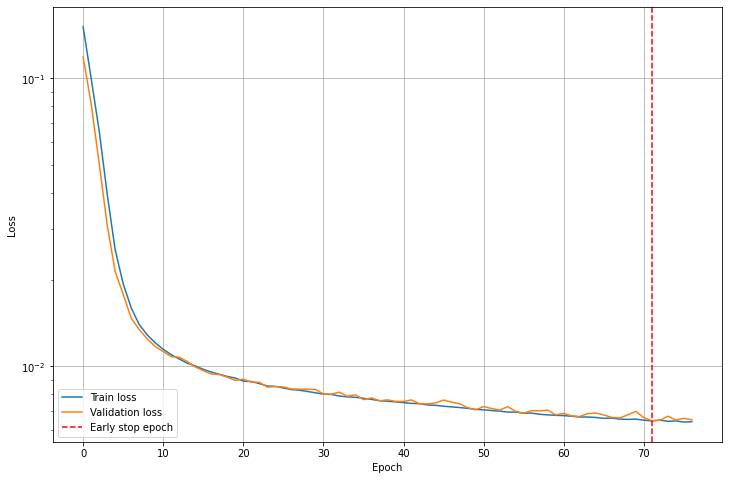

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(train_total_loss, label='Train loss')
plt.semilogy(val_total_loss, label='Validation loss')
plt.axvline(early_stop_epoch, color='red', linestyle='dashed', label='Early stop epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
print(f"TEST ERROR: {test_epoch(encoder, decoder, device, test_dataloader, loss_fn)}")

TEST ERROR: 0.006531698629260063


### Fine Tune for classification

Since the last model is the one with the one with the lower validation error I will use it to build the classifier

In [ ]:
#First of all we define the pretrained model
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [ ]:
#Now I restore the classifier Neural Network
class B_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
### I edit the training function
def train_epoch(encoder, decoder, classifier, device, dataloader, loss_fn, optimizer, is_decoder = False):
    # Set train mode for both the encoder and the decoder
    encoder.eval()
    decoder.eval()
    classifier.train()
    #Define the array to memorize the error
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, labels in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        labels = labels.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        if is_decoder:
            # Decode data
            decoded_data = decoder(encoded_data)
            # Classify the image
            out = classifier(decoded_data)
        else:
            # Classify the image from the latent space
            out = classifier(encoded_data)
        # Evaluate loss
        loss = loss_fn(out, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #Store the loss
        train_loss = np.append(train_loss, loss.data.cpu())
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
    return np.mean(train_loss)

In [ ]:
### I edit the Testing function
def test_epoch(encoder, decoder, classifier, device, dataloader, loss_fn, is_decoder = False):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    classifier.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        conc_label = []
        for image_batch, labels in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            labels = labels.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            if is_decoder:
                # Decode data
                decoded_data = decoder(encoded_data)
                # Classify the image
                out = classifier(decoded_data)
            else:
                # Classify the image from the latent space
                out = classifier(encoded_data)
            # Evaluate loss
            loss = loss_fn(out, labels)
            #Store the loss
            val_loss = np.append(val_loss, loss.data.cpu())
    return np.mean(val_loss)

In [ ]:
def training_validation_classifier(optim, loss_fn, train_dataloader, valid_dataloader, encoder, decoder, classifier, num_epochs = 50, early_stop = 0, is_decoder = False):
        train_loss = []
        train_total_loss = []
        val_total_loss = []
        early_stop_epoch = 0
        min_val_loss = 9999
        counter = 0
        for epoch in range(num_epochs):
            print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training (use the training function)
            train_loss = train_epoch(
                encoder=encoder, 
                decoder=decoder, 
                classifier = classifier,
                device=device, 
                dataloader=train_dataloader, 
                loss_fn=loss_fn, 
                optimizer=optim,
                is_decoder = is_decoder)
            ### Validation  (use the testing function)
            val_loss = test_epoch(
                encoder=encoder, 
                decoder=decoder, 
                classifier = classifier,
                device=device, 
                dataloader=valid_dataloader, 
                loss_fn=loss_fn,
                is_decoder = is_decoder)
            # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, train_loss))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))
            #Save the train and validation loss
            train_total_loss = np.append(train_total_loss, train_loss)
            val_total_loss = np.append(val_total_loss, val_loss)
            
            if early_stop != 0:
                if val_loss < min_val_loss:
                    print('\n SAVING NETWORK PARAMETERS....')
                    # Save network parameters
                    torch.save(encoder.state_dict(), 'encoder_params.pth')
                    torch.save(decoder.state_dict(), 'decoder_params.pth')
                    #Update minimum validation and counter
                    min_val_loss = val_loss
                    counter = 0
                    early_stop_epoch = epoch
                else:
                    #Update the counter
                    counter = counter + 1
                    #Check if we have reached the early stop point
                    if counter < early_stop:
                        print(f'Early stop counter: {counter}/{early_stop}')
                    else:
                        print(f'Early stop counter: {counter}/{early_stop}')
                        print('REACHED EARLY STOP POINT')
                        break

        print(f'\n\n\t AVERAGE TRAINING ERROR: {np.mean(train_total_loss)}')
        print(f'\n\t AVERAGE VALIDATION ERROR: {np.mean(val_total_loss)}')
        
        if early_stop != 0:
            return train_total_loss, val_total_loss, early_stop_epoch
        else:
            return train_total_loss, val_total_loss

            # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

In [ ]:
from torch.autograd import Variable

def accuracy(encoder, decoder, classifier, test_dataloader, is_decoder = False):
  encoder.to('cpu')
  decoder.to('cpu')
  classifier.to('cpu')
  encoder.eval()
  decoder.eval()
  classifier.eval()
  correct = 0
  total = 0
  print(is_decoder)
  for images, labels in test_dataloader:
      images = Variable(images.float())
      if is_decoder:
          outputs = classifier(decoder(encoder(images)))
      else:
          outputs = classifier(encoder(images))
            
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()
  print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

In [ ]:
torch.manual_seed(0)
b_cnn = B_CNN()

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

b_cnn.to(device)

Selected device: cuda


B_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': b_cnn.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Batch_Norm_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=126, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
classifier_training_loss, classifier_valid_loss, early_stop_epoch = training_validation_classifier(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder, b_cnn, early_stop = 10, is_decoder = True)

EPOCH 1/50


	 TRAINING - EPOCH 1/50 - loss: 0.497265




	 VALIDATION - EPOCH 1/50 - loss: 0.407643



 SAVING NETWORK PARAMETERS....
EPOCH 2/50


	 TRAINING - EPOCH 2/50 - loss: 0.343974




	 VALIDATION - EPOCH 2/50 - loss: 0.350545



 SAVING NETWORK PARAMETERS....
EPOCH 3/50


	 TRAINING - EPOCH 3/50 - loss: 0.311738




	 VALIDATION - EPOCH 3/50 - loss: 0.338391



 SAVING NETWORK PARAMETERS....
EPOCH 4/50


	 TRAINING - EPOCH 4/50 - loss: 0.294850




	 VALIDATION - EPOCH 4/50 - loss: 0.333147



 SAVING NETWORK PARAMETERS....
EPOCH 5/50


	 TRAINING - EPOCH 5/50 - loss: 0.281976




	 VALIDATION - EPOCH 5/50 - loss: 0.316377



 SAVING NETWORK PARAMETERS....
EPOCH 6/50


	 TRAINING - EPOCH 6/50 - loss: 0.264779




	 VALIDATION - EPOCH 6/50 - loss: 0.319333


Early stop counter: 1/10
EPOCH 7/50


	 TRAINING - EPOCH 7/50 - loss: 0.258123




	 VALIDATION - EPOCH 7/50 - loss: 0.308596



 SAVING NETWORK PARAMETERS....
EPOCH 8/50


	 TRAINING - EPOCH 8/50 - loss: 0.249273




	 VA

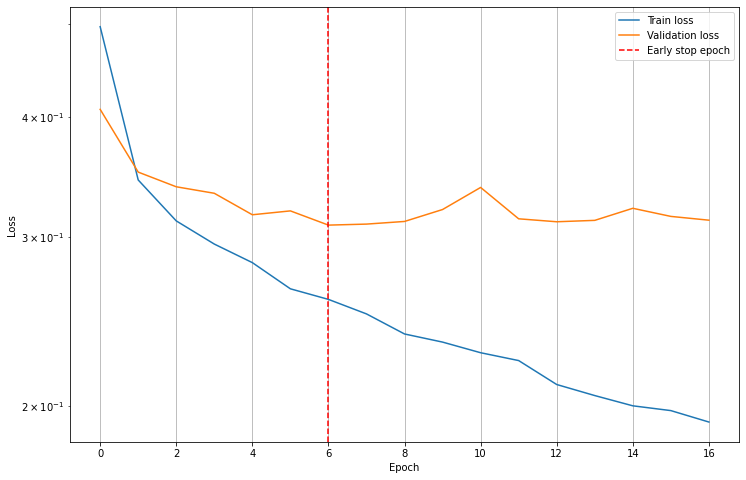

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(classifier_training_loss, label='Train loss')
plt.semilogy(classifier_valid_loss, label='Validation loss')
plt.axvline(early_stop_epoch, color='red', linestyle='dashed', label='Early stop epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy(encoder, decoder, b_cnn, test_dataloader, is_decoder = True)

True
Test Accuracy of the model on the 10000 test images: 89.1900 %


In [ ]:
class MLP_image_classifier(nn.Module):
  def __init__(self, Ni, Nh1, Nh2, No):
      super().__init__()
      self.mlp = nn.Sequential(
          nn.Flatten(),
          nn.Linear(Ni, Nh1),
          nn.ReLU(),
          nn.Linear(Nh1, Nh2),
          nn.Softmax(),
          nn.Linear(Nh2, No)
      )
      print('Network Initialized')

  def forward(self,x):
    x = self.mlp(x)

    return x

In [ ]:
torch.manual_seed(0)
Nh1 = 113
Nh2 = 365
No = 10
mlp_classifier = MLP_image_classifier(encoded_space_dim, Nh1, Nh2,No )

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

mlp_classifier.to(device)

Network Initialized
Selected device: cuda


MLP_image_classifier(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=126, out_features=113, bias=True)
    (2): ReLU()
    (3): Linear(in_features=113, out_features=365, bias=True)
    (4): Softmax(dim=None)
    (5): Linear(in_features=365, out_features=10, bias=True)
  )
)

In [ ]:
### Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.008518937654132403 # Learning rate
params_to_optimize = [
    {'params': mlp_classifier.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Batch_Norm_Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=126, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
classifier_training_loss, classifier_valid_loss, early_stop_epoch = training_validation_classifier(optim, loss_fn, train_dataloader, val_dataloader, encoder, decoder, mlp_classifier, early_stop = 10)

EPOCH 1/50


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




	 TRAINING - EPOCH 1/50 - loss: 1.460632




	 VALIDATION - EPOCH 1/50 - loss: 0.928403



 SAVING NETWORK PARAMETERS....
EPOCH 2/50


	 TRAINING - EPOCH 2/50 - loss: 0.805329




	 VALIDATION - EPOCH 2/50 - loss: 0.764835



 SAVING NETWORK PARAMETERS....
EPOCH 3/50


	 TRAINING - EPOCH 3/50 - loss: 0.706004




	 VALIDATION - EPOCH 3/50 - loss: 0.701742



 SAVING NETWORK PARAMETERS....
EPOCH 4/50


	 TRAINING - EPOCH 4/50 - loss: 0.574919




	 VALIDATION - EPOCH 4/50 - loss: 0.506183



 SAVING NETWORK PARAMETERS....
EPOCH 5/50


	 TRAINING - EPOCH 5/50 - loss: 0.438740




	 VALIDATION - EPOCH 5/50 - loss: 0.456908



 SAVING NETWORK PARAMETERS....
EPOCH 6/50


	 TRAINING - EPOCH 6/50 - loss: 0.392005




	 VALIDATION - EPOCH 6/50 - loss: 0.421646



 SAVING NETWORK PARAMETERS....
EPOCH 7/50


	 TRAINING - EPOCH 7/50 - loss: 0.361606




	 VALIDATION - EPOCH 7/50 - loss: 0.393531



 SAVING NETWORK PARAMETERS....
EPOCH 8/50


	 TRAINING - EPOCH 8/50 - loss: 0.337266




	 VALIDA

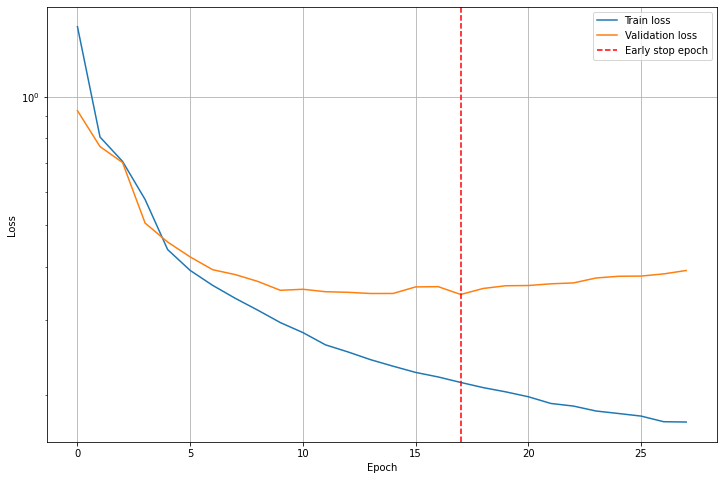

In [ ]:
# Plot losses of train and validation
plt.figure(figsize=(12,8))
plt.semilogy(classifier_training_loss, label='Train loss')
plt.semilogy(classifier_valid_loss, label='Validation loss')
plt.axvline(early_stop_epoch, color='red', linestyle='dashed', label='Early stop epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
accuracy(encoder, decoder, mlp_classifier, test_dataloader, is_decoder = False)

False


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test Accuracy of the model on the 10000 test images: 88.2700 %


### PCA and t-SNE

In [ ]:
print(encoded_space_dim)
encoder = Batch_Norm_Encoder(encoded_space_dim)

encoder.load_state_dict(torch.load('encoder_params.pth'))

encoder.to(device)

126


Batch_Norm_Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=126, bias=True)
  )
)

In [ ]:
#Create the dictionary for Mnist:
mnist_classes = {
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
    }
classes_values = {}

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
label_counter = np.zeros(10)
encoded_label = np.zeros((10, encoded_space_dim))
for sample in tqdm(test_dataset_MNIST):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]

    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_label[label] += encoded_img
    label_counter[label] += 1
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:10<00:00, 990.96it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 117,Enc. Variable 118,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,label
0,0.088955,0.127528,0.029143,0.043489,0.074575,-0.028387,-0.011460,-0.144867,0.034205,0.145033,...,-0.064903,0.014988,0.084981,-0.137534,-0.014607,0.040916,0.026478,-0.174763,-0.103348,9
1,-0.045405,-0.148316,-0.100343,0.080933,-0.039692,0.091515,0.001899,-0.080492,0.136213,-0.009424,...,0.017460,-0.019790,0.035825,0.184601,-0.006141,-0.005187,0.116358,0.028050,-0.044694,2
2,0.050329,0.140107,0.006658,0.093820,-0.114626,0.123231,-0.007862,-0.237801,-0.108806,-0.211523,...,-0.074655,-0.013343,0.090127,0.170391,0.016419,-0.015775,-0.042165,0.092374,0.063964,1
3,0.066267,0.002484,-0.025816,0.052209,0.091698,0.073483,-0.003994,-0.171196,-0.042021,-0.176853,...,-0.022145,0.074773,0.129298,0.069423,0.140284,0.043670,0.008191,-0.041490,0.036425,1
4,0.121378,-0.068255,0.069697,-0.014428,0.005318,0.067481,-0.006216,0.077653,0.032417,0.046669,...,-0.039025,0.045062,-0.098903,0.085902,-0.091377,-0.059699,-0.132908,0.009974,-0.049566,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.068309,0.220635,0.049477,-0.068195,0.084239,-0.041012,-0.059079,-0.009964,0.039376,-0.005191,...,-0.093904,0.059369,0.123379,-0.087491,-0.061645,0.044020,0.106123,-0.180674,-0.111639,9
9996,0.120031,-0.056904,-0.059448,0.127596,-0.033673,0.048752,0.003049,-0.027329,-0.016154,-0.079570,...,0.056097,0.026549,0.111993,0.005979,0.191519,0.103423,-0.001943,-0.089049,0.035214,1
9997,0.118058,0.021523,-0.071736,0.100906,-0.017699,-0.121144,0.060549,-0.030851,0.077678,-0.050419,...,-0.022949,0.062274,0.132346,-0.046540,0.072242,-0.035279,-0.060451,0.046809,-0.072762,8
9998,0.081011,-0.078190,-0.124862,-0.015719,0.004309,0.097742,0.077728,-0.070053,0.019497,-0.224875,...,0.036231,-0.060262,0.107547,-0.091237,0.157673,-0.019562,0.049530,-0.080424,0.105195,1


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[ 4.53756339, -0.29207717],
       [-2.49937589,  0.78049569],
       [-3.54676765, -0.40886726],
       ...,
       [ 3.46724704, -0.14161199],
       [-3.52648834, -0.47975558],
       [ 0.53944505, -0.18070346]])

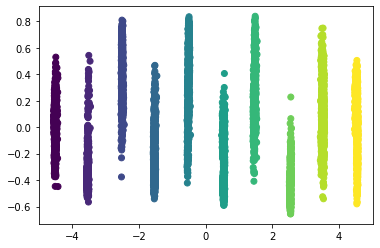

In [ ]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


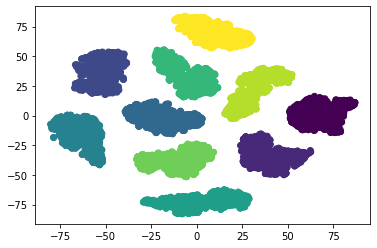

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

Now I create a custom image from a class

In [ ]:
#Create the dictionary with the mean values
for label in range (10):
    encoded_label[label]/= label_counter[label]
    encoded_label[label] = encoded_label[label].astype(float)
    classes_values[mnist_classes[label]] = encoded_label[label]


print(classes_values)

{'T-shirt': array([ 7.58900958e-02, -4.59045994e-02,  2.47790266e-02, -7.49881714e-03,
        2.56930609e-03,  3.06731628e-02,  4.37919647e-02, -2.37930271e-03,
        6.14542461e-02, -1.02525201e-01,  9.19797401e-02, -1.70383959e-02,
       -1.90226377e-02, -3.17048031e-03, -1.84244491e-02, -1.39115776e-01,
       -3.06983146e-03,  3.98256287e-02, -1.28229891e-01,  3.34802718e-02,
        1.95539211e-02,  1.00941271e-01, -6.71746268e-02, -1.41407648e-01,
        1.45278994e-02,  1.78638033e-01, -1.91520221e-02,  7.77211910e-02,
       -1.53902701e-01,  5.73987810e-02, -2.18082285e-02, -1.06551729e-01,
       -1.22085285e-01,  1.36058252e-02,  5.59091268e-03,  6.33809419e-03,
        8.36825427e-03, -1.50070131e-03,  5.08387850e-02, -2.64428047e-02,
        2.86234574e-02, -4.55062649e-02,  4.91811770e-02,  1.68883363e-02,
       -2.56221067e-02,  3.61322895e-02, -2.88091736e-01,  1.81039387e-02,
        7.36383155e-02, -1.90598129e-01, -7.42745197e-03, -1.72281490e-02,
        4.122

ORIGINAL IMAGE


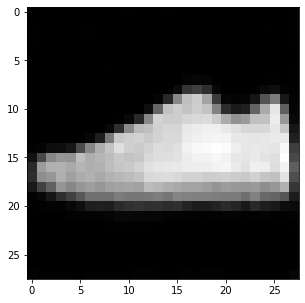

SAMPLE: 1


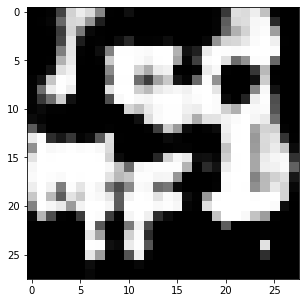

SAMPLE: 2


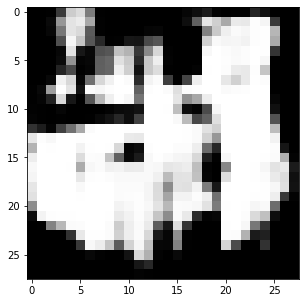

SAMPLE: 3


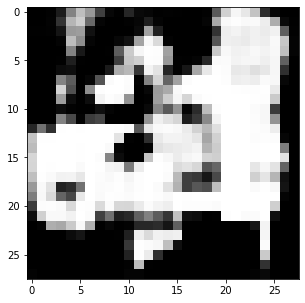

In [ ]:
### Generate a class image from the mean of all the test dataloader encoded
encoded_img = classes_values['Sneaker']
num_samples = 3

print("ORIGINAL IMAGE")
#We modify the sample
custom_encoded_sample = encoded_img
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)
decoder.to(device)

# Decode sample
decoder.eval()
with torch.no_grad():
    generated_img  = decoder(encoded_value)

plt.figure(figsize=(6,5))
plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
plt.show()

for i in range(num_samples):
    #We modify the sample
    custom_encoded_sample = encoded_img + np.random.rand(encoded_space_dim)
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)
    decoder.to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    print(f"SAMPLE: {i+1}")
    plt.figure(figsize=(6,5))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

### Variational Autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super().__init__()

        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(True),
        )
        self.enc_mu = nn.Linear(featureDim, zDim)
        self.enc_logVar = nn.Linear(featureDim, zDim)
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Initializing the fully-connected layer
        self.decFC1 = nn.Linear(zDim, featureDim)
        
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,20,20))
        
        self.decoder_cnn = nn.Sequential(
            #First decoder conv layer
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5),
            nn.ReLU(True),
            #Second decoder conv layer
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5)
        )

    def encoder(self, x):

        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        mu = self.enc_mu(x)
        logVar = self.enc_logVar(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):

        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = self.unflatten(x)
        x = torch.sigmoid(self.decoder_cnn(x))
        return x

    def forward(self, x):

        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [ ]:
import torch.nn.functional as F

#Define the loss function

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [ ]:
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 256
vae = VAE(zDim=encoded_space_dim)

In [ ]:
### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Movevae to the selected device
vae.to(device)

Selected device: cuda


VAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc_mu): Linear(in_features=12800, out_features=256, bias=True)
  (enc_logVar): Linear(in_features=12800, out_features=256, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (decFC1): Linear(in_features=256, out_features=12800, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 20, 20))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [ ]:
def train(num_epochs): 
    print("Starting Training:")
    for epoch in range(num_epochs):
        for idx, data in enumerate(train_dataloader, 0):
            imgs, _ = data
            imgs = imgs.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar
            out, mu, logVar = vae(imgs)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
            loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

            # Backpropagation based on the loss
            optim.zero_grad()
            loss.backward()
            optim.step()

        print('Epoch {}: Loss {}'.format(epoch, loss))

In [ ]:
train(15)

Starting Training:


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 58218.9609375
Epoch 1: Loss 56700.75
Epoch 2: Loss 55962.09765625
Epoch 3: Loss 52488.04296875
Epoch 4: Loss 51630.42578125
Epoch 5: Loss 51998.40234375
Epoch 6: Loss 51904.30859375
Epoch 7: Loss 49402.578125
Epoch 8: Loss 50862.8828125
Epoch 9: Loss 50066.16796875
Epoch 10: Loss 49790.4921875
Epoch 11: Loss 49609.0703125
Epoch 12: Loss 49542.2109375
Epoch 13: Loss 49922.3828125
Epoch 14: Loss 49888.98046875


In [ ]:
def test():
    test_loss = 0
    iteration = 0
    vae.eval()
    with torch.no_grad():
        for data in (test_dataloader):
            imgs, _ = data
            imgs = imgs.to(device)
            out, mu, logVar = vae(imgs)
            kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
            loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
            test_loss += loss
            iteration+=1
    test_loss = test_loss/iteration
    return test_loss.cpu().item()

            

In [ ]:
test = test()
print(f'TEST ERROR: '+ str(test))

TEST ERROR: 62302.76171875


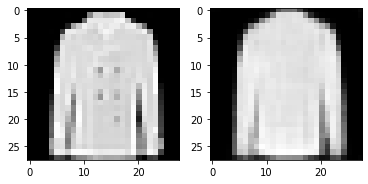

In [ ]:
## Printo some images to check the different between the original and the output of the vae
vae.eval()
with torch.no_grad():
    for data in random.sample(list(test_dataloader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img), cmap='gray')
        out, mu, logVAR = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg), cmap='gray')
        break